In [1]:
#Importing libraries
import numpy as np
import pandas as pd
from typing import List, Optional
from tqdm import tqdm
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb
import catboost as catb
from catboost.utils import get_roc_curve
from catboost import Pool
import lightgbm as lgb

import os
import json
import shap
import dill
import matplotlib.pyplot as plt
from collections import Counter
from PIL import  Image
import missingno as msno
%matplotlib inline

import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency, ks_2samp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer, log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder as le
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 400)
plt.style.use('seaborn-whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [54]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure(figsize=(20,10))
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
    return True

In [3]:
train = pd.read_csv("assignment2_data/assignment_2_train.csv")
test = pd.read_csv("assignment2_data/assignment_2_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


In [4]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,60605.000000,14458.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,80302.00000,83038.000000,106927.000000,68756.00000,24236.000000,11676.000000,33596.000000,33596.000000,134335.000000,59099.000000,20804.000000,18667.000000,20544.000000,131181.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,59099.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,134322.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.000000,106921.00000,106921.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,134089.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,131173.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.0,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180

In [6]:
#Разбиваем признаки по типам: числовые, нечисловые, цель
num_features = train.select_dtypes("number").columns.to_list()
dum_features = train.select_dtypes("object").columns.to_list()
target = num_features.pop(1)
len(num_features), len(dum_features), target

(379, 14, 'isFraud')

* Посмотрим на долю пропусков в числовых признаках и кол-во уникальных значений:

In [7]:
isna_share_data = train[num_features].isnull().sum()/train.shape[0]*100
isna_sum_data = train[num_features].isnull().sum()
nun_share_data = train[num_features].nunique(dropna=False)/train.shape[0]*100
nun_sum_data = train[num_features].nunique(dropna=False)

In [8]:
cols = {0: 'isna_share', 1: 'isna_sum', 2: 'nunique_share', 3: 'nunique'}
num_df = pd.concat([isna_share_data, isna_sum_data, nun_share_data, nun_sum_data], axis=1).rename(columns=cols)
num_df.head()

,isna_share,isna_sum,nunique_share,nunique
TransactionID,0.000000,0,100.000000,180000
TransactionDT,0.000000,0,96.366667,173460
TransactionAmt,0.000000,0,5.034444,9062
card1,0.000000,0,5.275556,9496
card2,1.450556,2611,0.277778,500


In [9]:
print(
    'Пропусков в данных довольно много:'
    '\n>50% пропусков:', num_df.loc[num_df['isna_share']>50].shape[0],
    '\n30%-50% пропусков:', num_df.loc[(num_df['isna_share']<50) & (num_df['isna_share']>30)].shape[0],
    '\n10%-30% пропусков:', num_df.loc[(num_df['isna_share']<30) & (num_df['isna_share']>10)].shape[0],
    '\n<10% пропусков:', num_df.loc[(num_df['isna_share']<10) & (num_df['isna_share']>0)].shape[0],
    '\n0 пропусков:', num_df.loc[num_df['isna_share']==0].shape[0]
)

Пропусков в данных довольно много:
>50% пропусков: 183 
30%-50% пропусков: 19 
10%-30% пропусков: 69 
<10% пропусков: 35 
0 пропусков: 73


Будем считать категориальными числовыми признаками те, что имеют до 0.02% уникальных значений среди всех:

In [10]:
num_df.loc[num_df['nunique_share']<0.02].sort_values('nunique', ascending=False).shape[0]

210

Сколько пропусков в категориальных числовых признаках:

In [11]:
print(
    'Пропусков в данных довольно много:'
    '\n>50% пропусков:', num_df.loc[(num_df['isna_share']>50) & (num_df['nunique_share']<0.02)].shape[0],
    '\n30%-50% пропусков:', num_df.loc[(num_df['isna_share']<50) & (num_df['isna_share']>30) & (num_df['nunique_share']<0.02)].shape[0],
    '\n10%-30% пропусков:', num_df.loc[(num_df['isna_share']<30) & (num_df['isna_share']>10) & (num_df['nunique_share']<0.02)].shape[0],
    '\n<10% пропусков:', num_df.loc[(num_df['isna_share']<10) & (num_df['isna_share']>0) & (num_df['nunique_share']<0.02)].shape[0],
    '\n0 пропусков:', num_df.loc[(num_df['isna_share']==0) & (num_df['nunique_share']<0.02)].shape[0]
)

Пропусков в данных довольно много:
>50% пропусков: 86 
30%-50% пропусков: 18 
10%-30% пропусков: 65 
<10% пропусков: 9 
0 пропусков: 32


In [12]:
#Посмотрим на значения в категориальных числовых признаках и избавимся от возможных, где пропущено <10%:
num_df.loc[(num_df['isna_share']<10) & (num_df['isna_share']>0) & (num_df['nunique_share']<0.02)]

,isna_share,isna_sum,nunique_share,nunique
V284,0.006111,11,0.005000,9
V286,0.006111,11,0.003333,6
V287,0.006111,11,0.013889,25
V297,0.006111,11,0.007778,14
V299,0.006111,11,0.013889,25
V302,0.006111,11,0.006667,12
V303,0.006111,11,0.008333,15
V304,0.006111,11,0.006667,12
V305,0.006111,11,0.001667,3


In [13]:
train.loc[train['V284'].isna()]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
23947,3010947,0,606971,139.944,C,12616,490.0,150.0,visa,NaN,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,3.0,6.0,0.0,3.0,0.0,3.0,3.0,5.0,0.0,5.0,5.0,5.0,6.0,3.0,498.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27325,3014325,0,686866,10.950,W,12616,490.0,150.0,visa,NaN,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,260.0,237.0,0.0,0.0,86.0,292.0,0.0,0.0,156.0,0.0,219.0,1.0,485.0,158.0,506.0,NaN,NaN,9.0,0.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [14]:
#Уберем 11 наблюдений, т.к. они имеют по многим признакам пустые значения:
train2 = train.loc[train['V284'].isna()==False]
train2.shape

(179989, 394)

Остальные числовые признаки с пустыми значениями я решил сейчас не обрабатывать, чтобы не тратить время.

* Посмотрим на долю пропусков в категориальных признаках и кол-во уникальных значений:

In [15]:
train2[dum_features].isnull().sum()/train.shape[0]*100

ProductCD         0.000000
card4             0.004444
card6             0.003889
P_emaildomain    15.799444
R_emaildomain    66.496667
M1               65.690000
M2               65.690000
M3               65.690000
M4               53.735000
M5               65.716667
M6               41.301111
M7               82.409444
M8               82.409444
M9               82.409444
dtype: float64

In [16]:
train2[dum_features].nunique(dropna=False)

ProductCD         5
card4             5
card6             5
P_emaildomain    60
R_emaildomain    61
M1                3
M2                3
M3                3
M4                4
M5                3
M6                3
M7                3
M8                3
M9                3
dtype: int64

Уберем из выборки наблюдения, где 'card4' и 'card6' не заполнено, т.к. по этим записям и в других признаках много не заполнено:

In [17]:
train2['card4'].value_counts(dropna=False)

visa                118284
mastercard           54501
american express      4818
discover              2378
NaN                      8
Name: card4, dtype: int64

In [18]:
train2['card6'].value_counts(dropna=False)

debit              122742
credit              57222
debit or credit        10
charge card             8
NaN                     7
Name: card6, dtype: int64

In [19]:
train2.loc[train2['card4'].isna()]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
9686,2996686,0,283553,40.0,H,16794,NaN,NaN,NaN,NaN,NaN,123.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,20.0,136.0,0.0,0.0,0.0,0.0,1868.0,46.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,19055.980469,210139.734375,0.0,0.0,0.0,1435.0,6765.0,1755.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11400,2998400,0,336773,50.0,H,12629,NaN,146.0,NaN,224.0,debit,327.0,87.0,NaN,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,123.875000,0.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [20]:
train2 = train2.loc[train2['card4'].isna()==False]
train2 = train2.loc[train2['card6'].isna()==False]

Заполним пропуски в 'P_emaildomain' и 'R_emaildomain' и создадим новые категориальные признаки на их основе с доменами 1-го и 2-го уровней

In [21]:
train2['P_emaildomain'].value_counts(dropna=False)

gmail.com           67189
yahoo.com           28990
NaN                 28438
hotmail.com         15055
anonymous.com       13325
aol.com              8581
comcast.net          2916
icloud.com           1677
outlook.com          1484
msn.com              1423
att.net              1223
sbcglobal.net        1092
verizon.net           971
live.com              894
bellsouth.net         713
ymail.com             654
me.com                624
cox.net               570
yahoo.com.mx          521
charter.net           372
optonline.net         362
live.com.mx           254
mac.com               214
rocketmail.com        201
earthlink.net         173
mail.com              147
outlook.es            142
roadrunner.com        119
gmail                 114
juno.com              111
embarqmail.com        109
windstream.net         95
twc.com                86
hotmail.es             85
frontier.com           79
hotmail.fr             68
q.com                  68
netzero.com            65
web.de      

In [22]:
train2['R_emaildomain'].value_counts(dropna=False)

NaN                 119688
gmail.com            24642
hotmail.com          10127
anonymous.com         9879
yahoo.com             5664
aol.com               2231
comcast.net           1185
outlook.com            824
icloud.com             605
yahoo.com.mx           519
msn.com                478
verizon.net            404
sbcglobal.net          374
live.com               339
cox.net                329
me.com                 293
bellsouth.net          284
att.net                283
live.com.mx            254
outlook.es             141
ymail.com              132
mac.com                126
optonline.net          110
hotmail.es              84
charter.net             80
hotmail.fr              69
prodigy.net.mx          62
web.de                  62
mail.com                58
earthlink.net           51
embarqmail.com          46
frontier.com            40
juno.com                38
yahoo.fr                34
windstream.net          33
gmx.de                  32
roadrunner.com          31
r

In [23]:
train2.loc[train2['P_emaildomain']=='gmail', 'P_emaildomain'] = 'gmail.com'
train2.loc[train2['R_emaildomain']=='gmail', 'R_emaildomain'] = 'gmail.com'
train2['P_emaildomain'].fillna('unknown', inplace=True)
train2['R_emaildomain'].fillna('unknown', inplace=True)

In [24]:
train2['P_emaildomain_zone'] = train2['P_emaildomain'].apply(lambda x: '.'.join(x.split('.')[1:]) if x!='unknown' else 'unknown')
train2['R_emaildomain_zone'] = train2['R_emaildomain'].apply(lambda x: '.'.join(x.split('.')[1:]) if x!='unknown' else 'unknown')
train2['P_emaildomain_domain'] = train2['P_emaildomain'].apply(lambda x: x.split('.')[0])
train2['R_emaildomain_domain'] = train2['R_emaildomain'].apply(lambda x: x.split('.')[0])

In [25]:
train2['P_emaildomain_zone'].value_counts(dropna=False)

com        141304
unknown     28438
net          8749
com.mx        775
es            262
de            126
fr            119
rr.com        103
net.mx         62
co.uk          33
co.jp           6
Name: P_emaildomain_zone, dtype: int64

In [26]:
train2['R_emaildomain_zone'].value_counts(dropna=False)

unknown    119688
com         55694
net          3204
com.mx        773
es            241
de            126
fr            118
net.mx         62
rr.com         34
co.uk          24
co.jp           7
edu             6
Name: R_emaildomain_zone, dtype: int64

In [27]:
train2['P_emaildomain_domain'].value_counts(dropna=False)

gmail           67303
yahoo           29632
unknown         28438
hotmail         15226
anonymous       13325
aol              8581
comcast          2916
icloud           1677
outlook          1626
msn              1423
att              1223
live             1163
sbcglobal        1092
verizon           971
bellsouth         713
ymail             654
me                624
cox               570
charter           372
optonline         362
mac               214
rocketmail        201
earthlink         173
mail              147
roadrunner        119
netzero           114
juno              111
embarqmail        109
windstream         95
twc                86
frontier           79
q                  68
web                64
aim                63
prodigy            62
cfl                59
frontiernet        59
centurylink        49
suddenlink         45
sc                 44
cableone           37
gmx                33
ptd                23
protonmail         20
servicios-ta       12
Name: P_em

In [28]:
train2['R_emaildomain_domain'].value_counts(dropna=False)

unknown         119688
gmail            24666
hotmail          10295
anonymous         9879
yahoo             6281
aol               2231
comcast           1185
outlook            965
live               608
icloud             605
msn                478
verizon            404
sbcglobal          374
cox                329
me                 293
bellsouth          284
att                283
ymail              132
mac                126
optonline          110
charter             80
web                 62
prodigy             62
mail                58
earthlink           51
embarqmail          46
frontier            40
juno                38
windstream          33
gmx                 32
roadrunner          31
rocketmail          30
cfl                 28
twc                 23
q                   21
ptd                 19
aim                 18
suddenlink          15
netzero             15
cableone            12
servicios-ta        12
frontiernet         11
centurylink          7
scranton   

У оставшихся показателей заполним пустые значения условным 'unknown'

In [29]:
dum_na = train2[dum_features].isnull().sum()
col_na_lst = dum_na.loc[dum_na > 0].index.tolist()
col_na_lst

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [30]:
train2[col_na_lst] = train2[col_na_lst].fillna('unknown')

In [31]:
dum_features = train2.select_dtypes("object").columns.to_list()

In [32]:
train2[dum_features].isnull().sum()

ProductCD               0
card4                   0
card6                   0
P_emaildomain           0
R_emaildomain           0
M1                      0
M2                      0
M3                      0
M4                      0
M5                      0
M6                      0
M7                      0
M8                      0
M9                      0
P_emaildomain_zone      0
R_emaildomain_zone      0
P_emaildomain_domain    0
R_emaildomain_domain    0
dtype: int64

## XGBoost

отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [78]:
data = train2[num_features]

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 379 cols
x_valid.shape = 35996 rows, 379 cols


In [79]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [80]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

Обучаем модель, пока в течении 50 итераций не будет улучшаться метрика качества:

In [81]:
%%time
model_xgb1 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[13:11:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65188	valid-auc:0.64177
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.79327	valid-auc:0.79289
[20]	train-auc:0.83850	valid-auc:0.83252
[30]	train-auc:0.86373	valid-auc:0.86094
[40]	train-auc:0.87421	valid-auc:0.86969
[50]	train-auc:0.88208	valid-auc:0.87790
[60]	train-auc:0.88939	valid-auc:0.88315
[70]	train-auc:0.89286	valid-auc:0.88562
[80]	train-auc:0.89515	valid-auc:0.88773
[90]	train-auc:0.89789	valid-auc:0.89002
[100]	train-auc:0.89989	valid-auc:0.89140
[110]	train-auc:

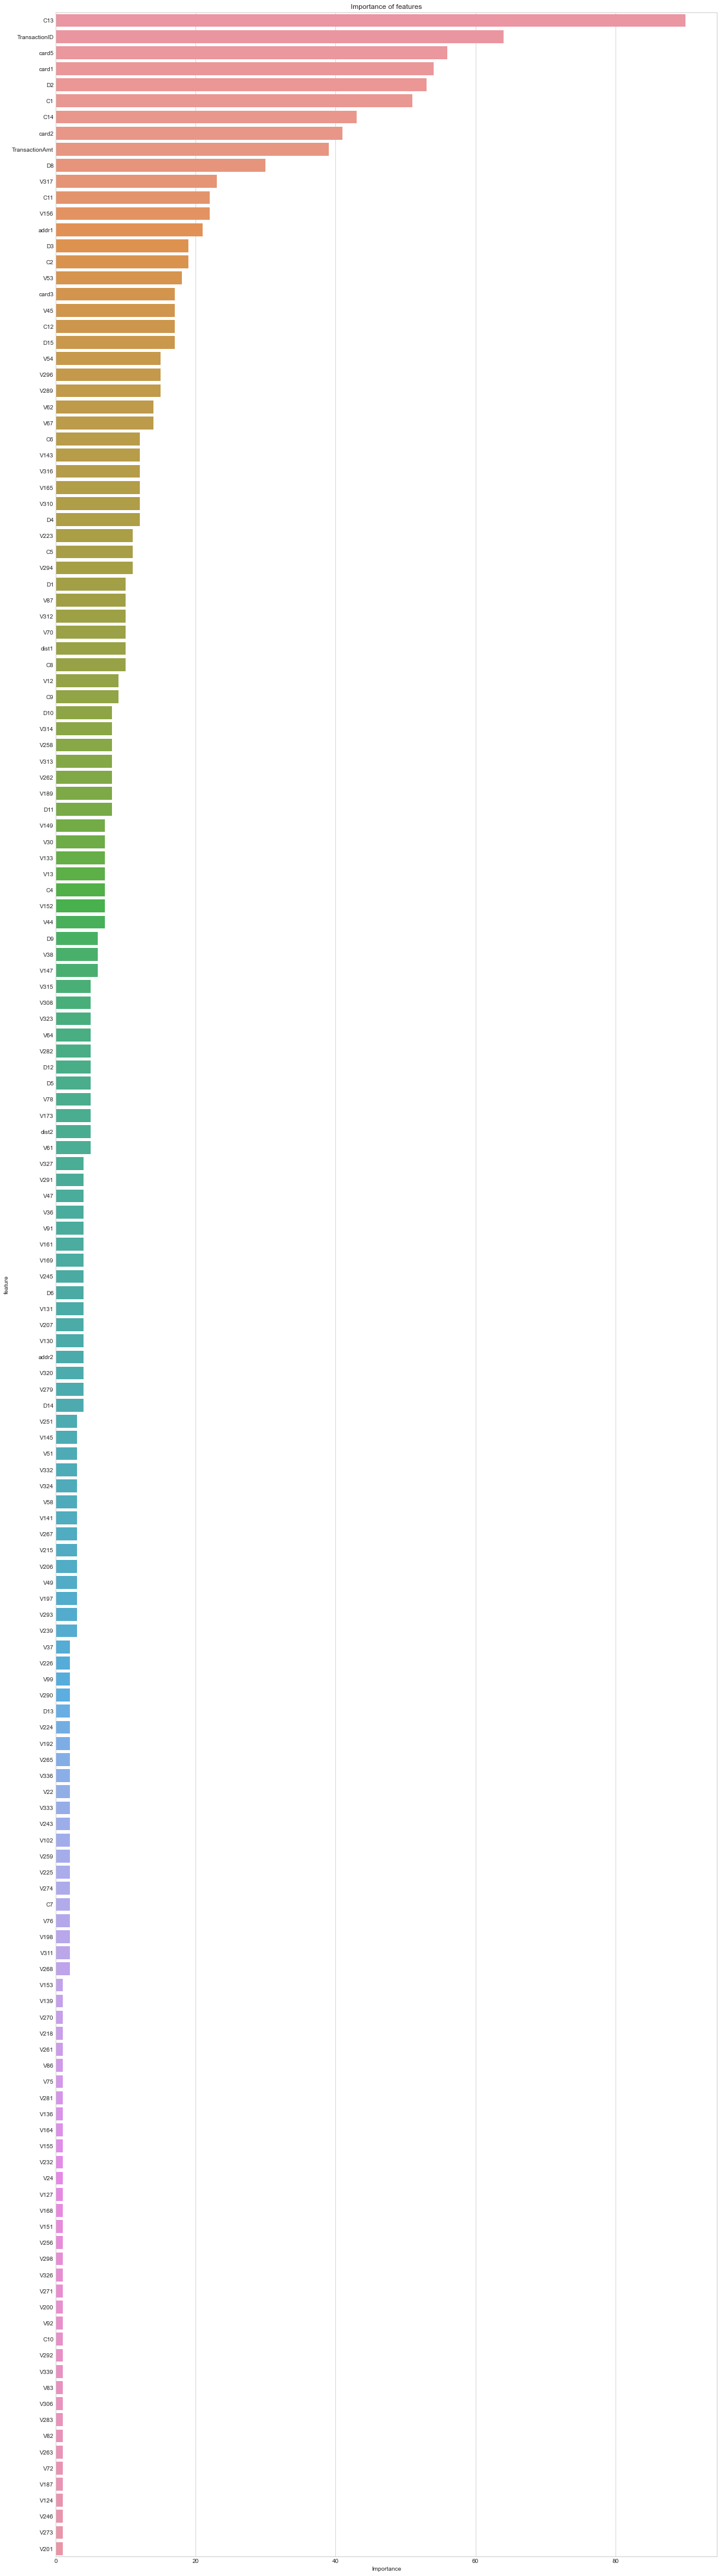

In [82]:
feature_important = model_xgb1.get_score(importance_type='weight')
top_feat = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)

In [83]:
#Заведем список моделей и результатов для дальнейшего анализа
models_lst = []
y_train_pred = model_xgb1.predict(dtrain)
y_valid_pred = model_xgb1.predict(dvalid)
models_lst.append(('XGBoost with num features', model_xgb1, y_train, y_train_pred, y_valid, y_valid_pred))

#### Добавим в модель категориальные признаки:

In [84]:
data = train2[num_features + dum_features].apply(le().fit_transform)

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 397 cols
x_valid.shape = 35996 rows, 397 cols


In [85]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [86]:
%%time
model_xgb2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[13:13:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.59074	valid-auc:0.56962
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.79613	valid-auc:0.78321
[20]	train-auc:0.82860	valid-auc:0.82071
[30]	train-auc:0.86592	valid-auc:0.86120
[40]	train-auc:0.87347	valid-auc:0.86718
[50]	train-auc:0.88536	valid-auc:0.88026
[60]	train-auc:0.89227	valid-auc:0.88526
[70]	train-auc:0.89763	valid-auc:0.88860
[80]	train-auc:0.90204	valid-auc:0.89211
[90]	train-auc:0.90545	valid-auc:0.89448
[100]	train-auc:0.90831	valid-auc:0.89660
[110]	train-auc:

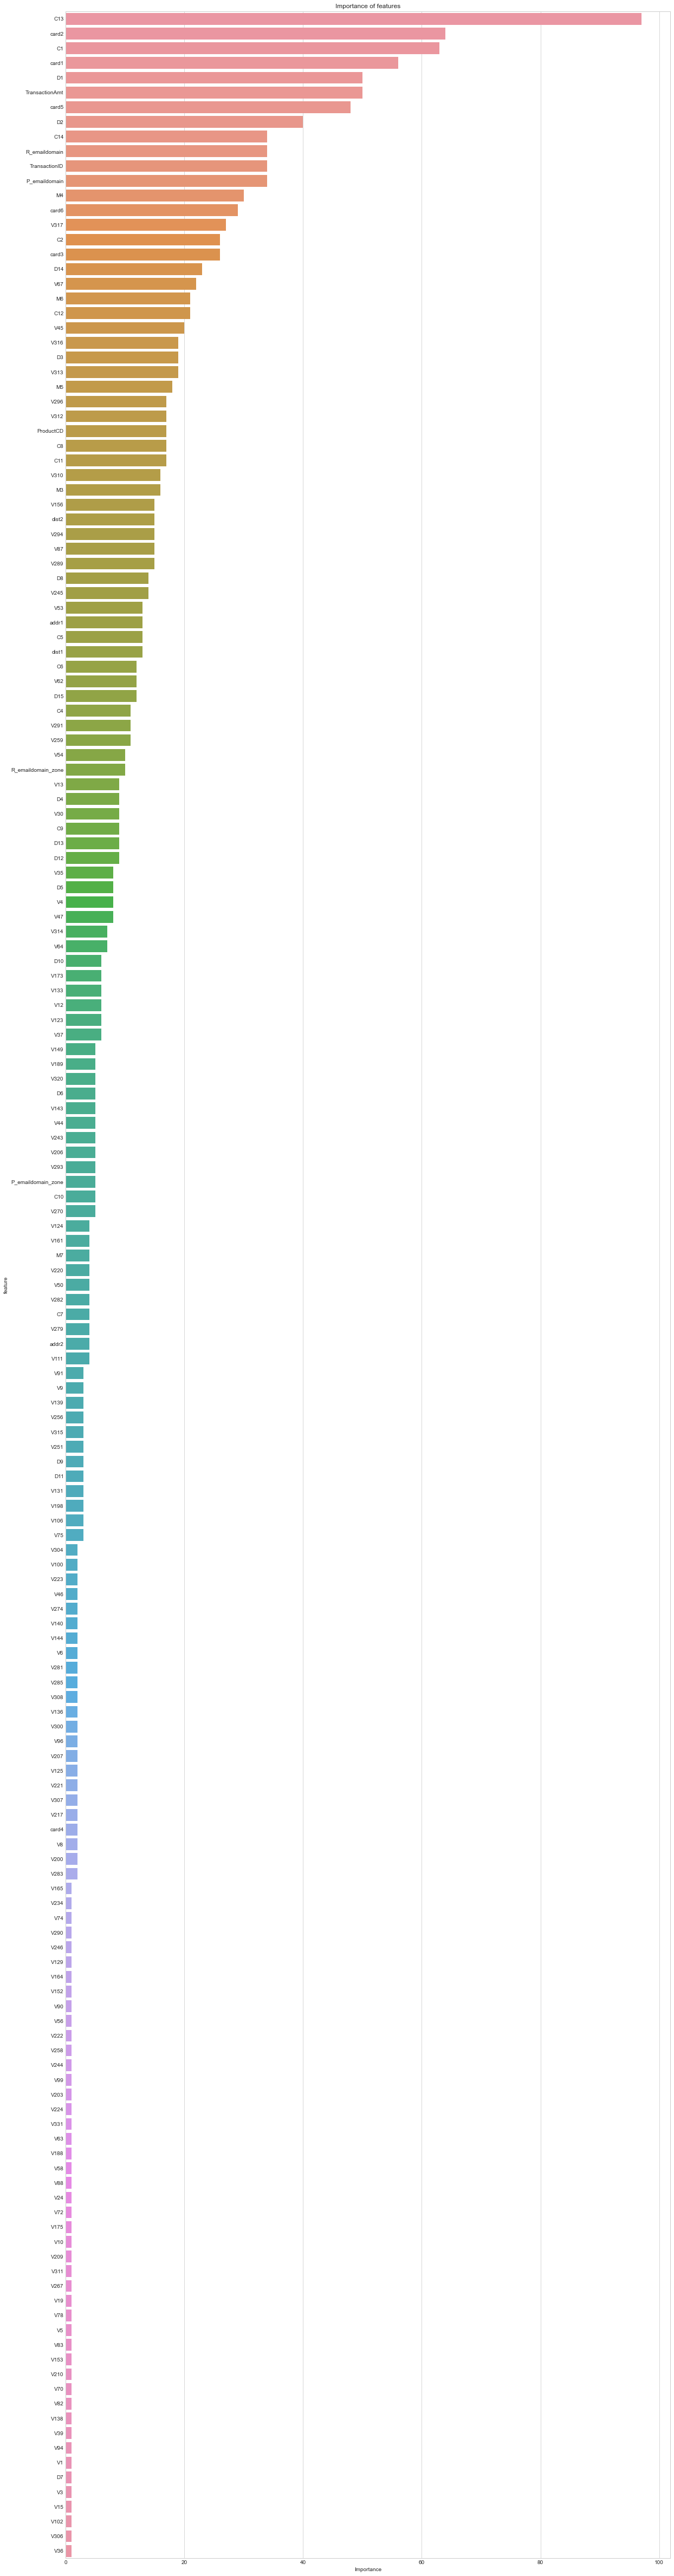

In [87]:
feature_important = model_xgb2.get_score(importance_type='weight')
top_feat = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)

In [88]:
y_train_pred = model_xgb2.predict(dtrain)
y_valid_pred = model_xgb2.predict(dvalid)
models_lst.append(('XGBoost with cat features', model_xgb2, y_train, y_train_pred, y_valid, y_valid_pred))

## LightGBM

для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [89]:
data = train2[num_features]

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 379 cols
x_valid.shape = 35996 rows, 379 cols


In [90]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [91]:
%%time
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model_lgb1 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.836276	valid_1's auc: 0.832578
[20]	training's auc: 0.840096	valid_1's auc: 0.835934
[30]	training's auc: 0.869676	valid_1's auc: 0.858633
[40]	training's auc: 0.871927	valid_1's auc: 0.862355
[50]	training's auc: 0.875345	valid_1's auc: 0.865914
[60]	training's auc: 0.881157	valid_1's auc: 0.874724
[70]	training's auc: 0.885231	valid_1's auc: 0.877807
[80]	training's auc: 0.887186	valid_1's auc: 0.879191
[90]	training's auc: 0.889527	valid_1's auc: 0.882008
[100]	training's auc: 0.893148	valid_1's auc: 0.884566
[110]	training's auc: 0.894927	valid_1's auc: 0.884481
[120]	training's auc: 0.896417	valid_1's auc: 0.885243
[130]	training's auc: 0.897857	valid_1's auc: 0.886024
[140]	training's auc: 0.900828	valid_1's auc: 0.888389
[150]	training's auc: 0.902306	valid_1's auc: 0.890194
[160]	training's auc: 0.903897	valid_1's auc: 0.891732
[170]	training's auc: 0.905442	valid_1's auc: 0.893038
[180]	trainin

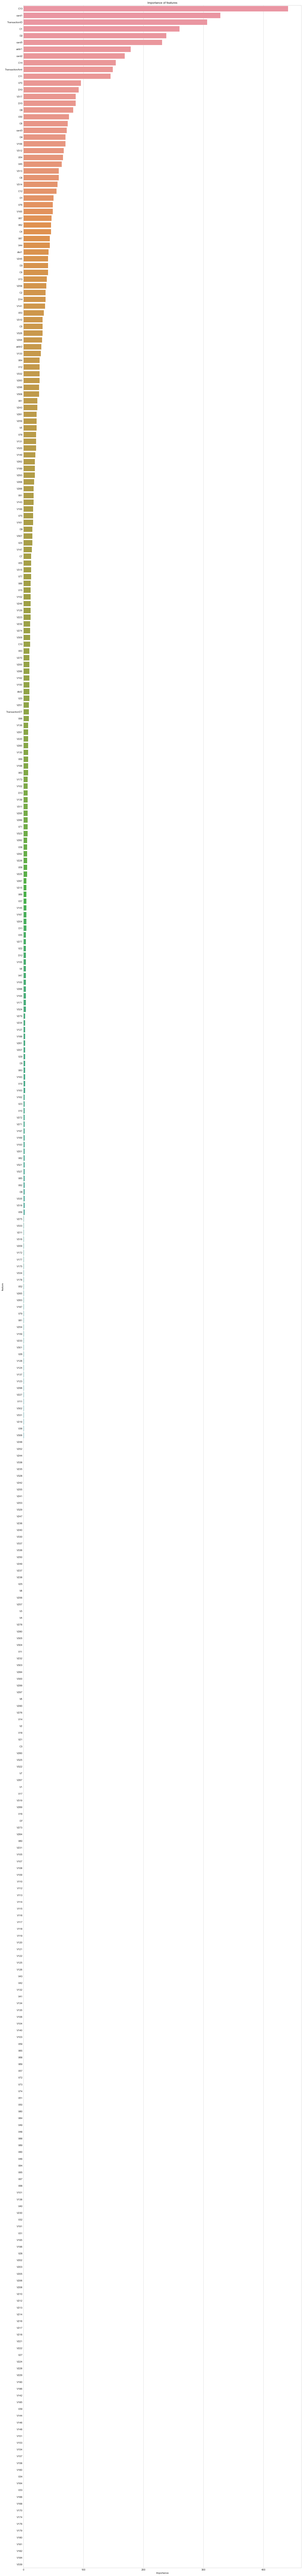

In [92]:
top_feat = show_feature_importances(data.columns.tolist(), model_lgb1.feature_importance().tolist(), get_top=30)

In [93]:
y_train_pred = model_lgb1.predict(x_train)
y_valid_pred = model_lgb1.predict(x_valid)
models_lst.append(('LightGBM with cat features', model_lgb1, y_train, y_train_pred, y_valid, y_valid_pred))

обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [94]:
data = train2[num_features + dum_features].apply(le().fit_transform)

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 397 cols
x_valid.shape = 35996 rows, 397 cols


In [95]:
%%time
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model_lgb2 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.83109	valid_1's auc: 0.824227
[20]	training's auc: 0.858911	valid_1's auc: 0.848592
[30]	training's auc: 0.864265	valid_1's auc: 0.854166
[40]	training's auc: 0.869874	valid_1's auc: 0.86034
[50]	training's auc: 0.872436	valid_1's auc: 0.864315
[60]	training's auc: 0.876005	valid_1's auc: 0.867096
[70]	training's auc: 0.882658	valid_1's auc: 0.874879
[80]	training's auc: 0.886267	valid_1's auc: 0.877741
[90]	training's auc: 0.889673	valid_1's auc: 0.879736
[100]	training's auc: 0.892417	valid_1's auc: 0.882783
[110]	training's auc: 0.894558	valid_1's auc: 0.884814
[120]	training's auc: 0.898323	valid_1's auc: 0.887826
[130]	training's auc: 0.900917	valid_1's auc: 0.889887
[140]	training's auc: 0.903441	valid_1's auc: 0.892352
[150]	training's auc: 0.906537	valid_1's auc: 0.894397
[160]	training's auc: 0.909251	valid_1's auc: 0.895748
[170]	training's auc: 0.911058	valid_1's auc: 0.897194
[180]	training'

In [96]:
y_train_pred = model_lgb2.predict(x_train)
y_valid_pred = model_lgb2.predict(x_valid)
models_lst.append(('LightGBM with cat features LabelEncoder', model_lgb2, y_train, y_train_pred, y_valid, y_valid_pred))

обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [97]:
data = train2[num_features + dum_features]
data[dum_features] = data[dum_features].astype('category')

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 397 cols
x_valid.shape = 35996 rows, 397 cols


In [98]:
%%time
dtrain = lgb.Dataset(
    data=x_train, label=y_train, categorical_feature=dum_features
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid, categorical_feature=dum_features
)

model_lgb3 = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.836448	valid_1's auc: 0.832703
[20]	training's auc: 0.863845	valid_1's auc: 0.856637
[30]	training's auc: 0.870658	valid_1's auc: 0.860337
[40]	training's auc: 0.875369	valid_1's auc: 0.867746
[50]	training's auc: 0.878934	valid_1's auc: 0.871564
[60]	training's auc: 0.887919	valid_1's auc: 0.884342
[70]	training's auc: 0.891714	valid_1's auc: 0.886979
[80]	training's auc: 0.894689	valid_1's auc: 0.889647
[90]	training's auc: 0.898311	valid_1's auc: 0.892561
[100]	training's auc: 0.901418	valid_1's auc: 0.894656
[110]	training's auc: 0.903609	valid_1's auc: 0.895864
[120]	training's auc: 0.90605	valid_1's auc: 0.898058
[130]	training's auc: 0.908567	valid_1's auc: 0.899821
[140]	training's auc: 0.910743	valid_1's auc: 0.900709
[150]	training's auc: 0.91294	valid_1's auc: 0.901795
[160]	training's auc: 0.914982	valid_1's auc: 0.90292
[170]	training's auc: 0.916691	valid_1's auc: 0.904172
[180]	training's

In [99]:
y_train_pred = model_lgb3.predict(x_train)
y_valid_pred = model_lgb3.predict(x_valid)
models_lst.append(('LightGBM with cat features internal method', model_lgb3, y_train, y_train_pred, y_valid, y_valid_pred))

Качество LGB модели со встроенной обработкой категориальных признаков выше, чем LabelEncoder в LGB и XGB, который применил я:
- LabelEncoder XGB (4 мин 10 сек):
    - train-auc: 0.92056
    - valid-auc: 0.90459
- LabelEncoder LGB (31 сек): 	
    - training's auc: 0.916478
    - valid_1's auc: 0.900598
- __Встроенная обработка LGB (28 сек):__
    - training's auc: 0.92076
    - valid_1's auc: 0.906268

## CatBoost

для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [100]:
data = train2[num_features]
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 379 cols
x_valid.shape = 35996 rows, 379 cols


In [101]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 40,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [102]:
%%time
model_catb1 = catb.CatBoostClassifier(**cb_params)
model_catb1.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)])

0:	test: 0.6369544	test1: 0.6384366	best: 0.6384366 (0)	total: 139ms	remaining: 2m 18s
40:	test: 0.8511820	test1: 0.8455194	best: 0.8455194 (40)	total: 2.83s	remaining: 1m 6s
80:	test: 0.8603065	test1: 0.8532491	best: 0.8533474 (78)	total: 5.76s	remaining: 1m 5s
120:	test: 0.8655880	test1: 0.8586191	best: 0.8587100 (115)	total: 9.13s	remaining: 1m 6s
160:	test: 0.8727000	test1: 0.8666518	best: 0.8666565 (159)	total: 12.8s	remaining: 1m 6s
200:	test: 0.8796939	test1: 0.8742607	best: 0.8742607 (200)	total: 16.4s	remaining: 1m 5s
240:	test: 0.8832641	test1: 0.8775791	best: 0.8775839 (239)	total: 20s	remaining: 1m 2s
280:	test: 0.8860465	test1: 0.8800354	best: 0.8800354 (280)	total: 23.4s	remaining: 59.8s
320:	test: 0.8883766	test1: 0.8825007	best: 0.8825007 (320)	total: 26.6s	remaining: 56.3s
360:	test: 0.8901933	test1: 0.8841061	best: 0.8841061 (360)	total: 29.8s	remaining: 52.8s
400:	test: 0.8912982	test1: 0.8850186	best: 0.8850186 (400)	total: 33s	remaining: 49.3s
440:	test: 0.8928504	

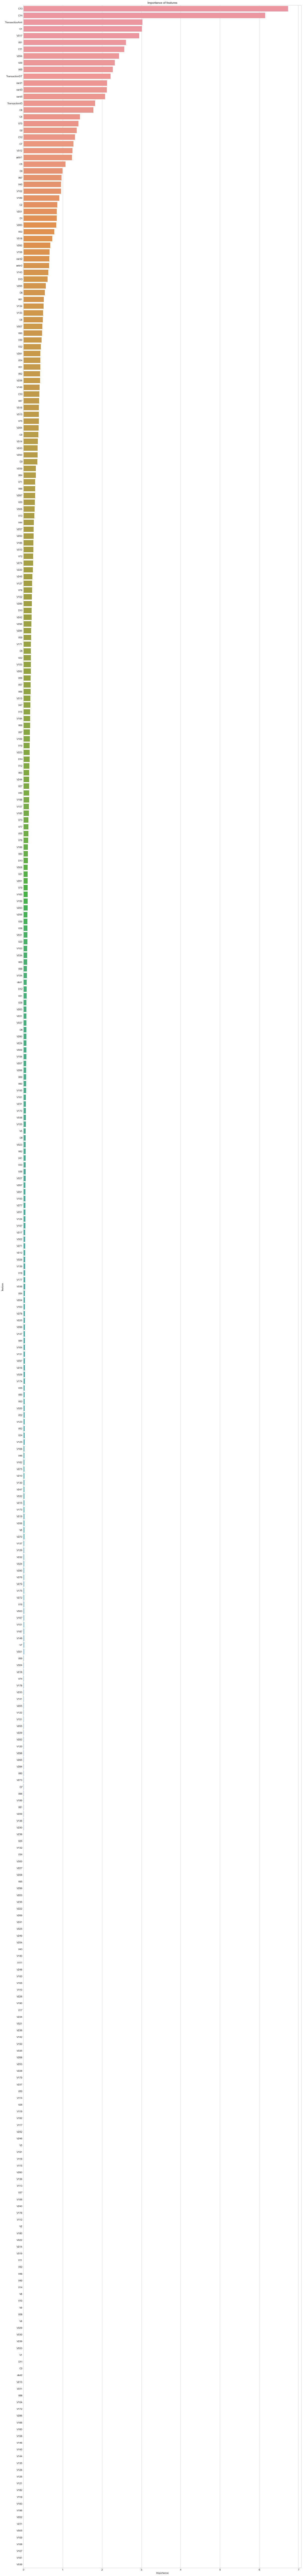

In [103]:
top_feat = show_feature_importances(data.columns.tolist(), model_catb1.get_feature_importance().tolist(), get_top=30)

In [104]:
y_train_pred = model_catb1.predict(x_train)
y_valid_pred = model_catb1.predict(x_valid)
models_lst.append(('CatBoost with num features', model_catb1, y_train, y_train_pred, y_valid, y_valid_pred))

обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [105]:
data = train2[num_features + dum_features].apply(le().fit_transform)

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 397 cols
x_valid.shape = 35996 rows, 397 cols


In [106]:
%%time
model_catb2 = catb.CatBoostClassifier(**cb_params)
model_catb2.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)])

0:	test: 0.6499023	test1: 0.6243927	best: 0.6243927 (0)	total: 79.2ms	remaining: 1m 19s
40:	test: 0.8587105	test1: 0.8532947	best: 0.8532947 (40)	total: 3.28s	remaining: 1m 16s
80:	test: 0.8714570	test1: 0.8678286	best: 0.8678286 (80)	total: 6.6s	remaining: 1m 14s
120:	test: 0.8824226	test1: 0.8796735	best: 0.8796735 (120)	total: 9.85s	remaining: 1m 11s
160:	test: 0.8890104	test1: 0.8846965	best: 0.8846965 (160)	total: 13.1s	remaining: 1m 8s
200:	test: 0.8940401	test1: 0.8892620	best: 0.8892620 (200)	total: 16.3s	remaining: 1m 4s
240:	test: 0.8980482	test1: 0.8924068	best: 0.8924068 (240)	total: 19.5s	remaining: 1m 1s
280:	test: 0.9010470	test1: 0.8944855	best: 0.8944855 (280)	total: 22.8s	remaining: 58.4s
320:	test: 0.9031054	test1: 0.8961159	best: 0.8961165 (319)	total: 26.3s	remaining: 55.6s
360:	test: 0.9052052	test1: 0.8977801	best: 0.8977801 (360)	total: 30.2s	remaining: 53.4s
400:	test: 0.9067944	test1: 0.8986544	best: 0.8986544 (400)	total: 34.2s	remaining: 51.1s
440:	test: 0.9

In [107]:
y_train_pred = model_catb2.predict(x_train)
y_valid_pred = model_catb2.predict(x_valid)
models_lst.append(('CatBoost with cat features LabelEncoder', model_catb2, y_train, y_train_pred, y_valid, y_valid_pred))

обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [108]:
data = train2[num_features + dum_features]
# data[dum_features] = data[dum_features].astype('category')

x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    train2[target], train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 143981 rows, 397 cols
x_valid.shape = 35996 rows, 397 cols


In [109]:
%%time
model_catb3 = catb.CatBoostClassifier(**cb_params)
model_catb3.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], cat_features=dum_features)

0:	test: 0.7334929	test1: 0.7279323	best: 0.7279323 (0)	total: 496ms	remaining: 8m 15s
40:	test: 0.8533275	test1: 0.8425354	best: 0.8425354 (40)	total: 19.1s	remaining: 7m 27s
80:	test: 0.8661153	test1: 0.8584621	best: 0.8588255 (79)	total: 37.4s	remaining: 7m 4s
120:	test: 0.8725731	test1: 0.8661355	best: 0.8661355 (120)	total: 55.5s	remaining: 6m 42s
160:	test: 0.8798711	test1: 0.8748837	best: 0.8749120 (159)	total: 1m 13s	remaining: 6m 21s
200:	test: 0.8869321	test1: 0.8825772	best: 0.8825772 (200)	total: 1m 31s	remaining: 6m 2s
240:	test: 0.8904667	test1: 0.8857055	best: 0.8857055 (240)	total: 1m 48s	remaining: 5m 41s
280:	test: 0.8938748	test1: 0.8891609	best: 0.8891609 (280)	total: 2m 6s	remaining: 5m 23s
320:	test: 0.8972840	test1: 0.8920937	best: 0.8920937 (320)	total: 2m 24s	remaining: 5m 5s
360:	test: 0.8997381	test1: 0.8941586	best: 0.8941586 (360)	total: 2m 42s	remaining: 4m 47s
400:	test: 0.9013653	test1: 0.8951587	best: 0.8951587 (400)	total: 3m	remaining: 4m 29s
440:	tes

In [110]:
y_train_pred = model_catb3.predict(x_train)
y_valid_pred = model_catb3.predict(x_valid)
models_lst.append(('CatBoost with cat features internal method', model_catb3, y_train, y_train_pred, y_valid, y_valid_pred))

Качество LGB модели со встроенной обработкой немного ниже, чем LabelEncoder CatBoost, но если учитывать скорость обучения, то это наилучшее решение при сопостовимом качестве. Встроенная обработка в CatBoost оказалась на удивление ниже качеством, чем LabelEncoder, и скорость обучения самая низкая из всех моделей:
- LabelEncoder XGB (4 мин 10 сек):
    - train-auc: 0.92056
    - valid-auc: 0.90459
- LabelEncoder LGB (27 сек): 	
    - train-auc: 0.916478
    - valid-auc: 0.900598
- Встроенная обработка LGB __(26 сек)__:
    - train-auc: 0.92076
    - valid-auc: 0.906268
- LabelEncoder CatBoost (1мин 31 сек): 	
    - train-auc: __0.9242538__
    - valid-auc: __0.9087330__
- Встроенная обработка CatBoost (7 мин 29 сек):
    - train-auc: 0.9144405
    - valid-auc: 0.9042353

построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

XGBoost with num features


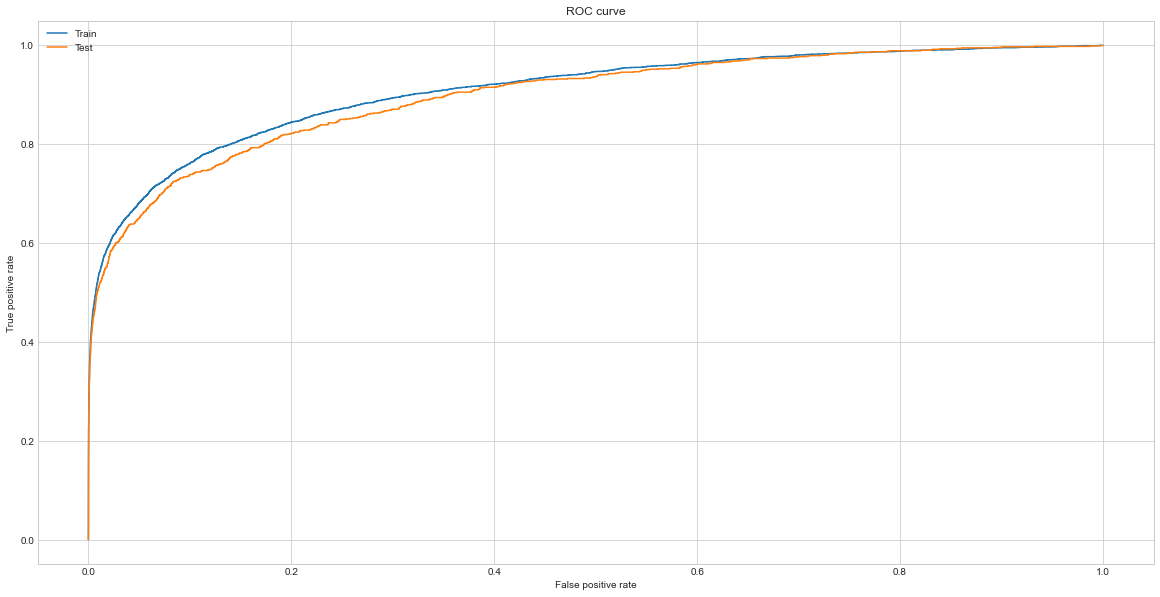

XGBoost with cat features


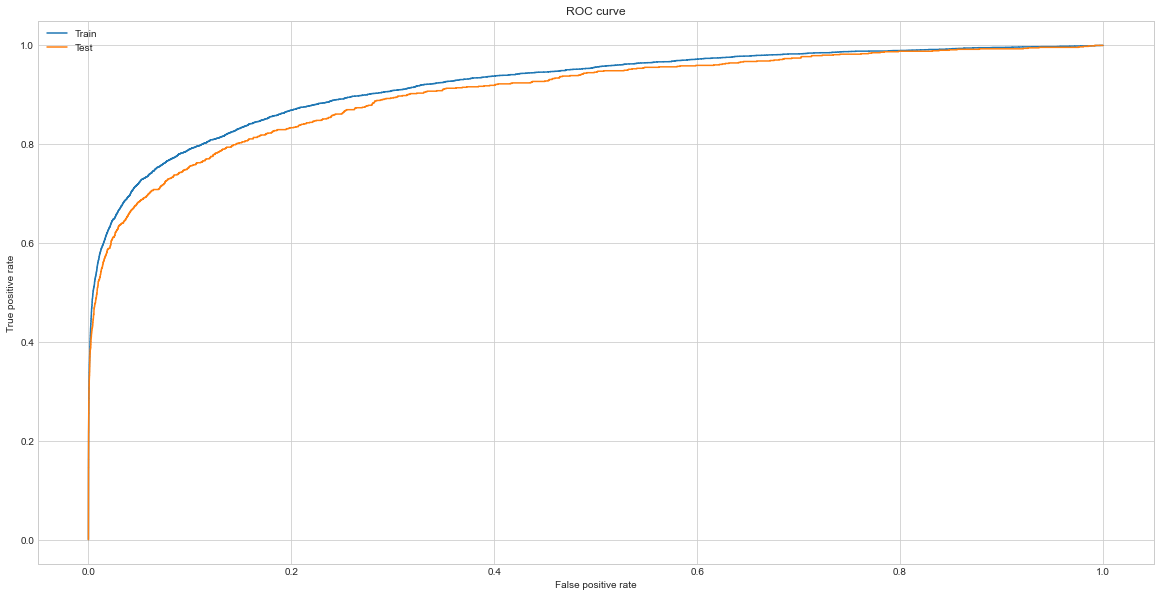

LightGBM with cat features


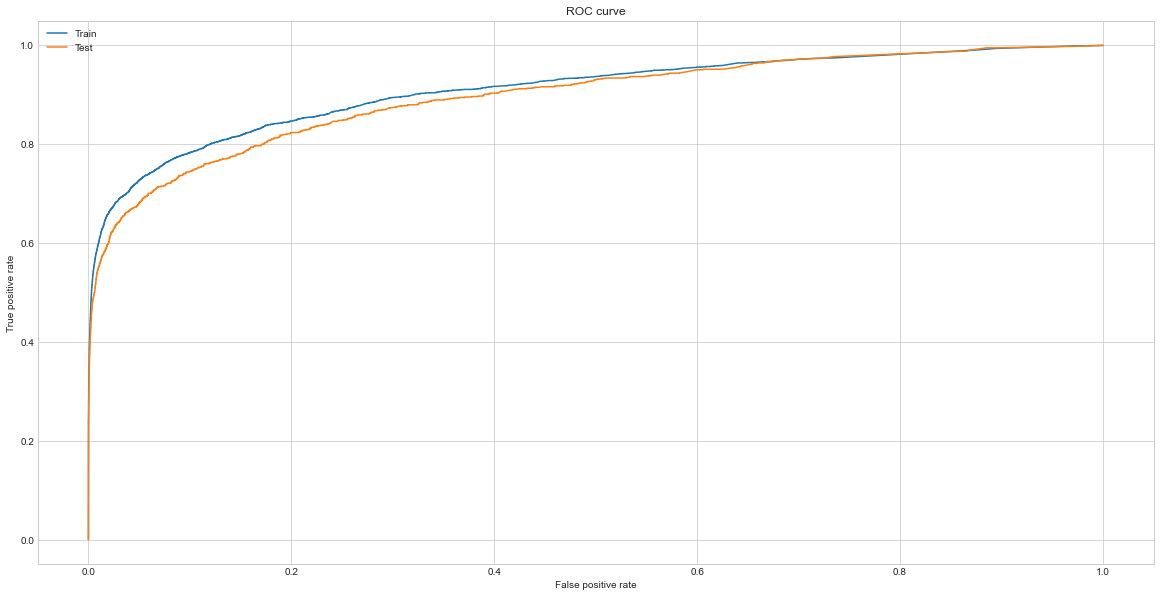

LightGBM with cat features LabelEncoder


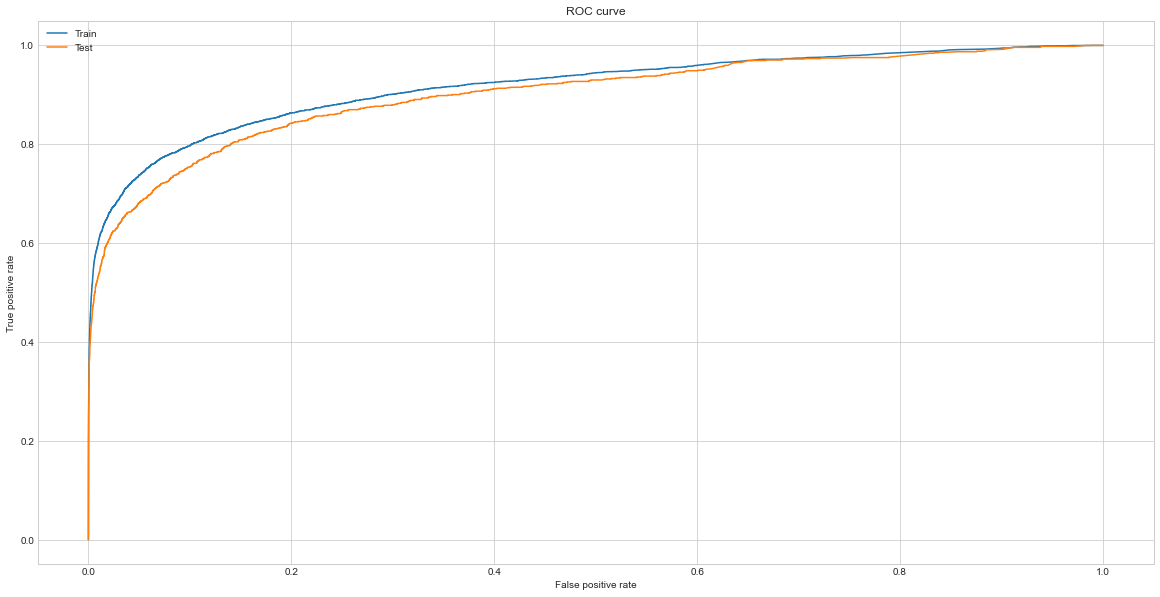

LightGBM with cat features internal method


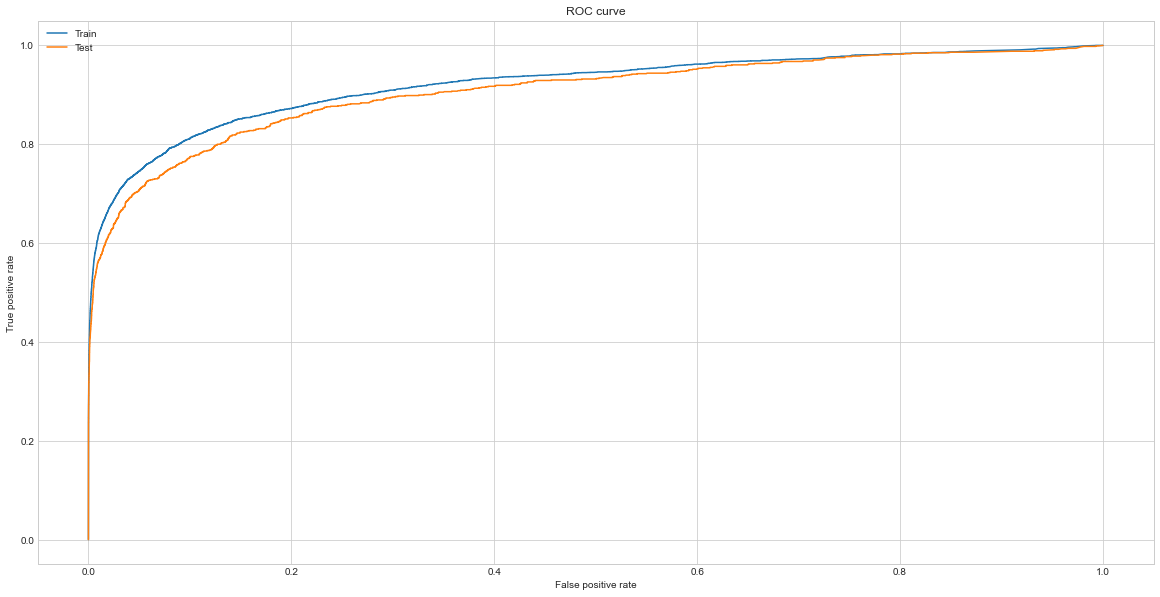

CatBoost with num features


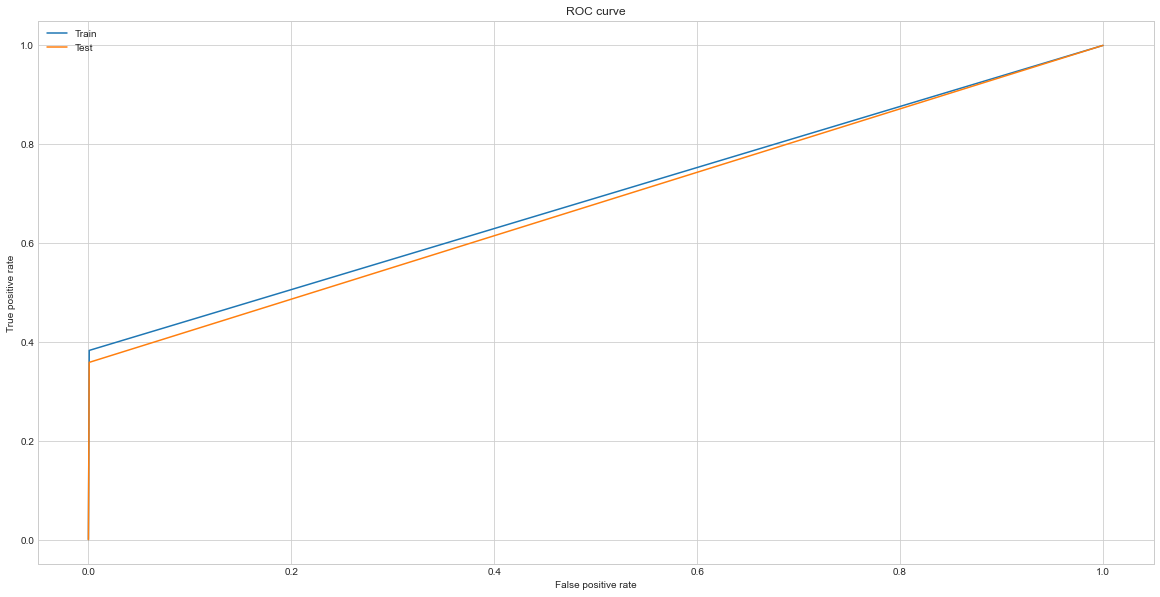

CatBoost with cat features LabelEncoder


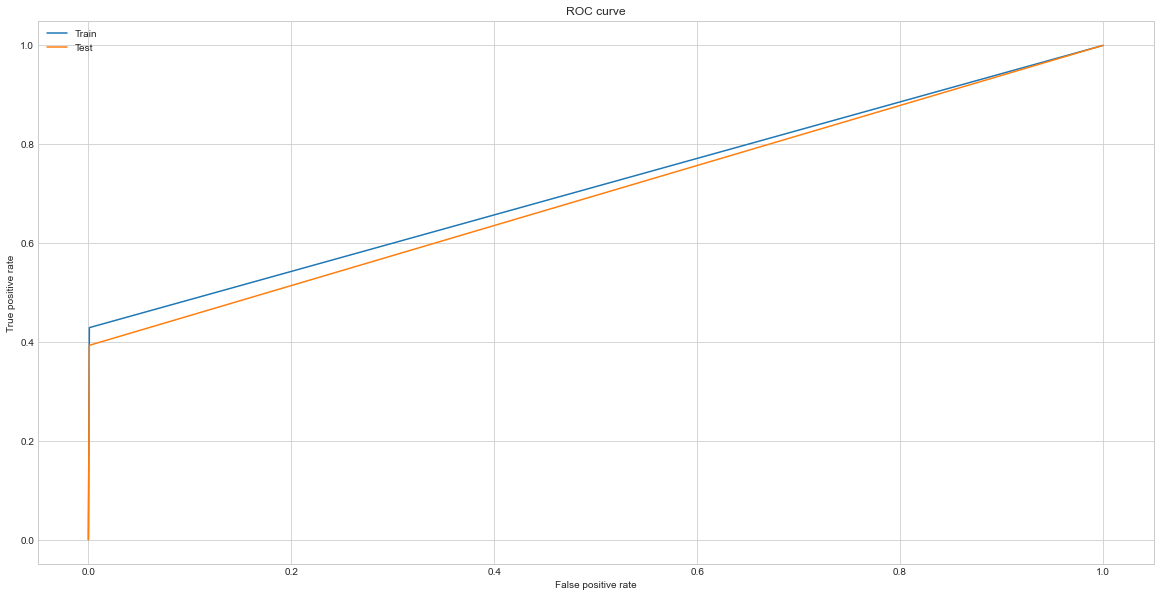

CatBoost with cat features internal method


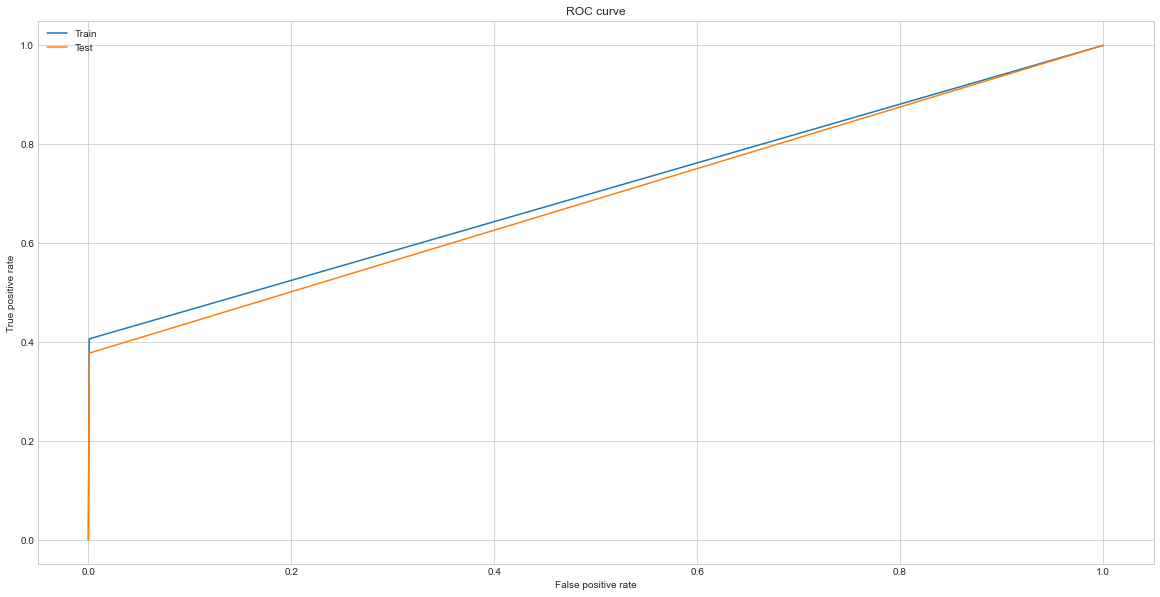

In [112]:
for model in models_lst:
    print(model[0])
    plot_roc_curve(model[2], model[3], model[4], model[5])

Из графиков ROC AUC кривой выше видно:
- Переобучение есть у всех моделей, и визуально кажется, что у всех примерно одинаковое переобучение. Возможно, у модели XGBoost с использованием числовых признаков переобучение меньше.
- Не обычный график кривой у меня получился для моделей CatBoost. Похоже, что-то некорректно работает. Я так и не разобрался, в чем причина.
- Встроенный метод визуализации ROC AUC в catboost работает лучше (см. ниже). Судя по нему наименьшее переобучение на моделе с числовыми характеристиками и с собственным методом обработки категориальных признаков

In [132]:
data = train2[num_features]
x_train1, x_valid1 = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train1, y_valid1 = train_test_split(
    train2[target], train_size=0.8, random_state=1
)

data = train2[num_features + dum_features].apply(le().fit_transform)

x_train2, x_valid2 = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train2, y_valid2 = train_test_split(
    train2[target], train_size=0.8, random_state=1
)

data = train2[num_features + dum_features]

x_train3, x_valid3 = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train3, y_valid3 = train_test_split(
    train2[target], train_size=0.8, random_state=1
)

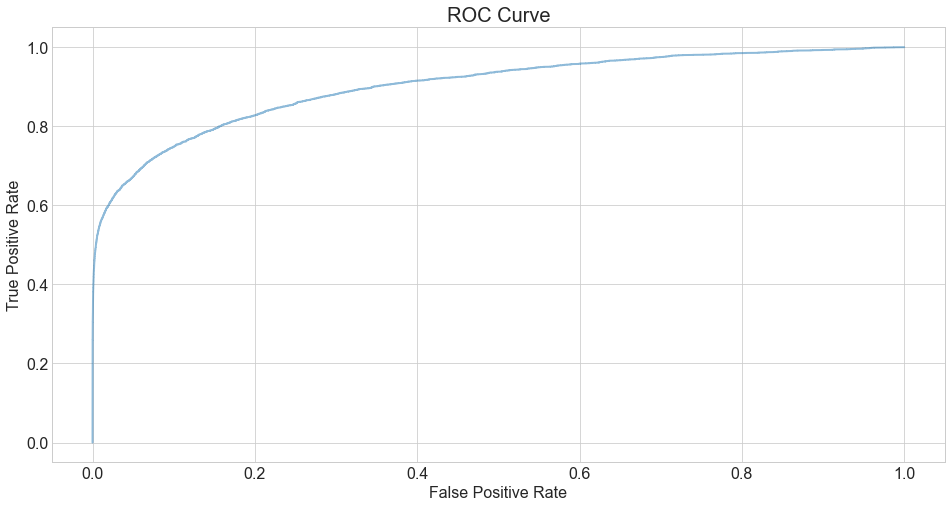

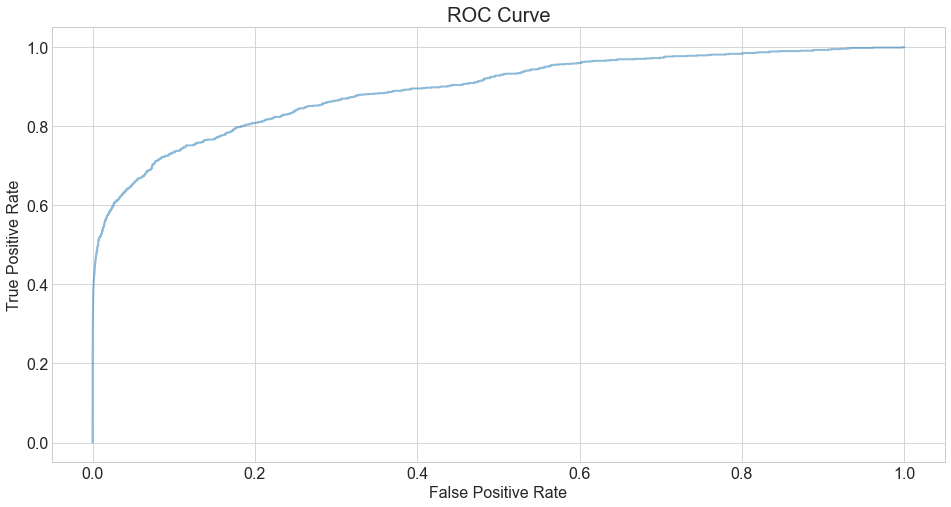

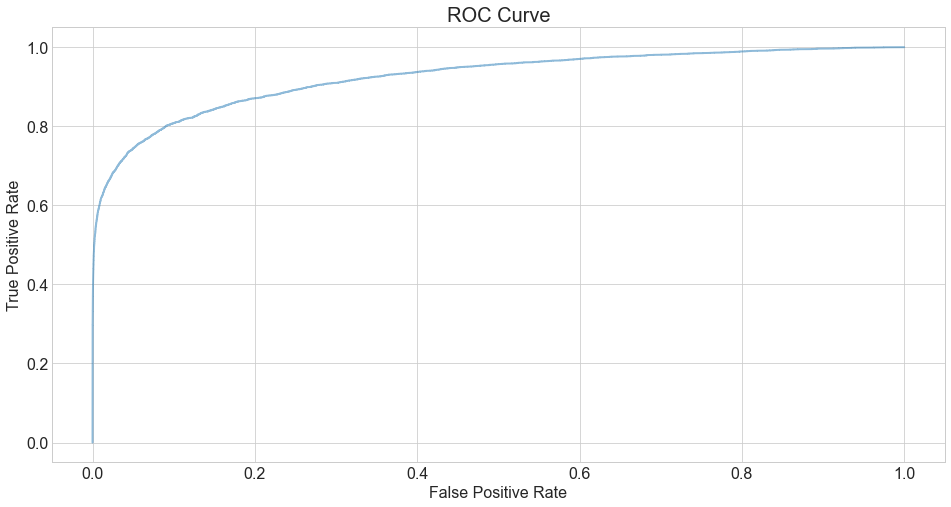

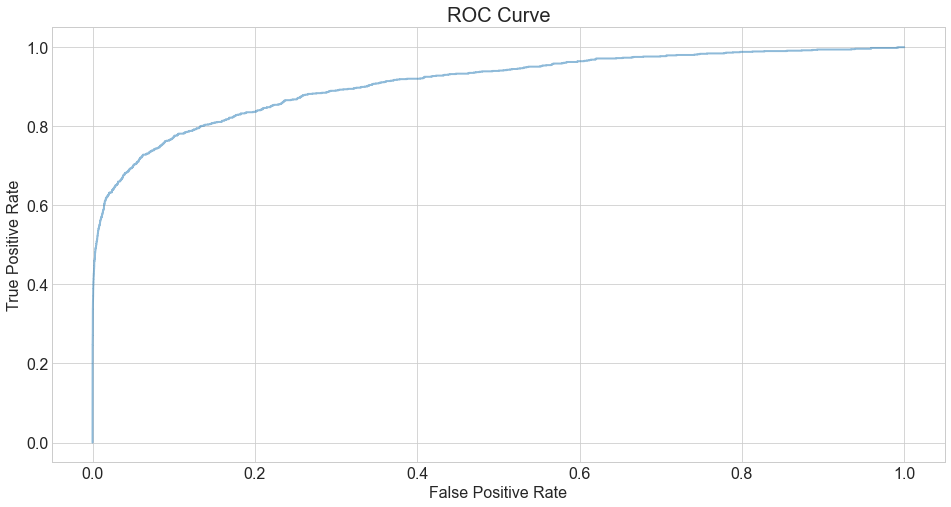

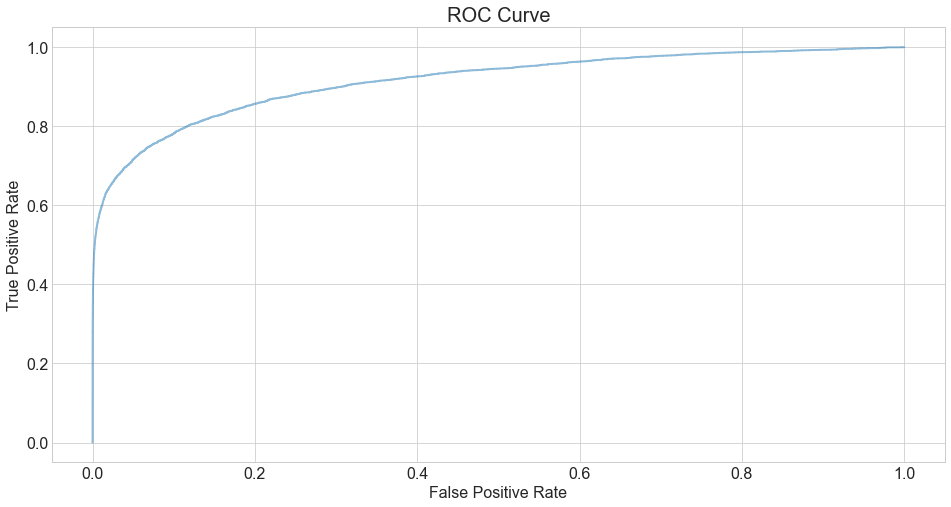

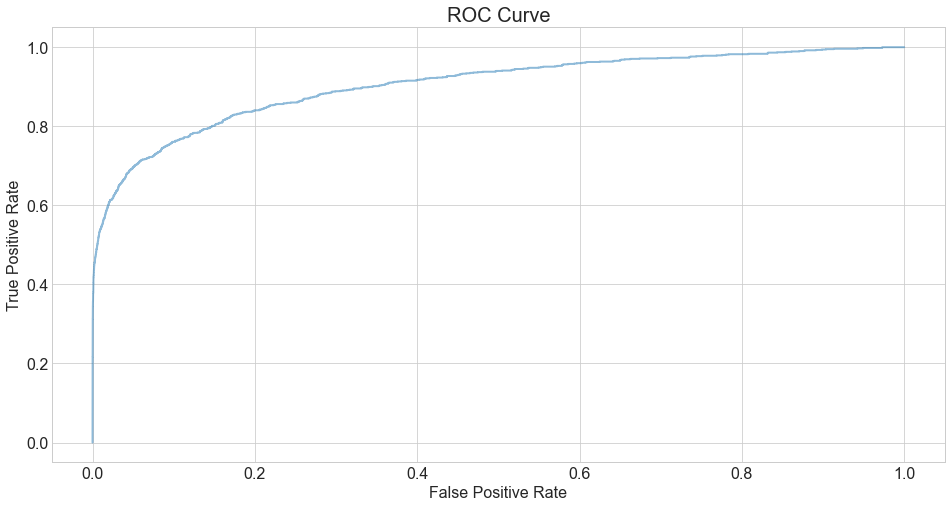

In [133]:
catboost_pool1 = Pool(x_train1, y_train1)
catboost_pool_valid1 = Pool(x_valid1, y_valid1)
catboost_pool2 = Pool(x_train2, y_train2)
catboost_pool_valid2 = Pool(x_valid2, y_valid2)
catboost_pool3 = Pool(x_train3, y_train3, cat_features=dum_features)
catboost_pool_valid3 = Pool(x_valid3, y_valid3, cat_features=dum_features)
fpr_train1, tpr_train1, _ = get_roc_curve(model_catb1, catboost_pool1, plot=True)
fpr_valid1, tpr_valid1, _ = get_roc_curve(model_catb1, catboost_pool_valid1, plot=True)
fpr_train2, tpr_train2, _ = get_roc_curve(model_catb2, catboost_pool2, plot=True)
fpr_valid2, tpr_valid2, _ = get_roc_curve(model_catb2, catboost_pool_valid2, plot=True)
fpr_train3, tpr_train3, _ = get_roc_curve(model_catb3, catboost_pool3, plot=True)
fpr_valid3, tpr_valid3, _ = get_roc_curve(model_catb3, catboost_pool_valid3, plot=True)

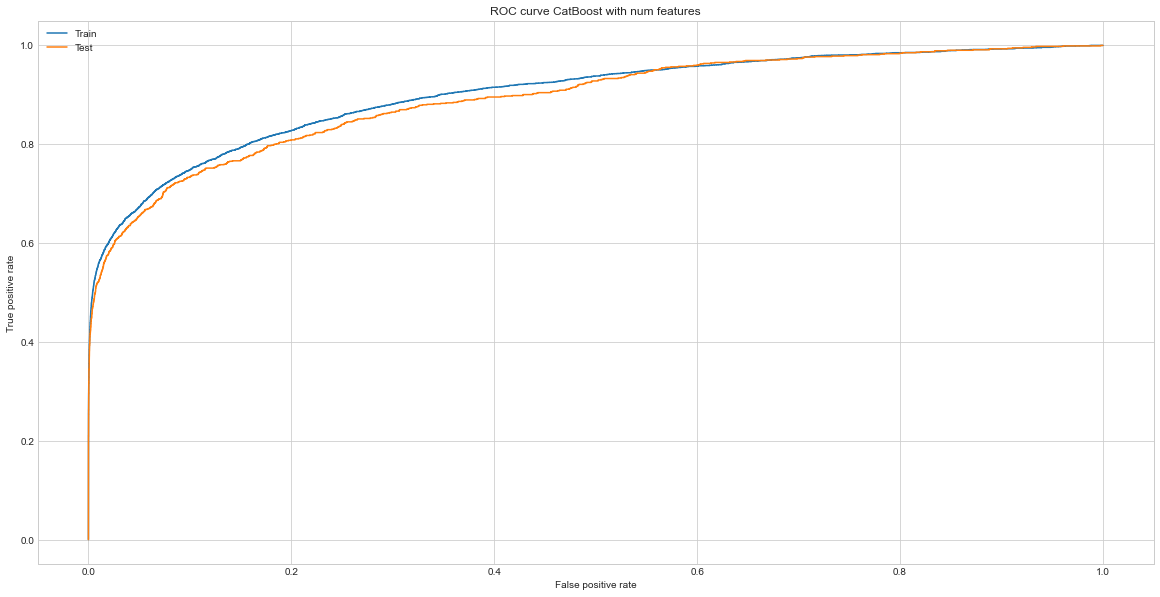

In [134]:
plt.figure(figsize=(20,10))
plt.plot(fpr_train1, tpr_train1, label='Train')
plt.plot(fpr_valid1, tpr_valid1, label='Test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve CatBoost with num features')
plt.legend()
plt.show()

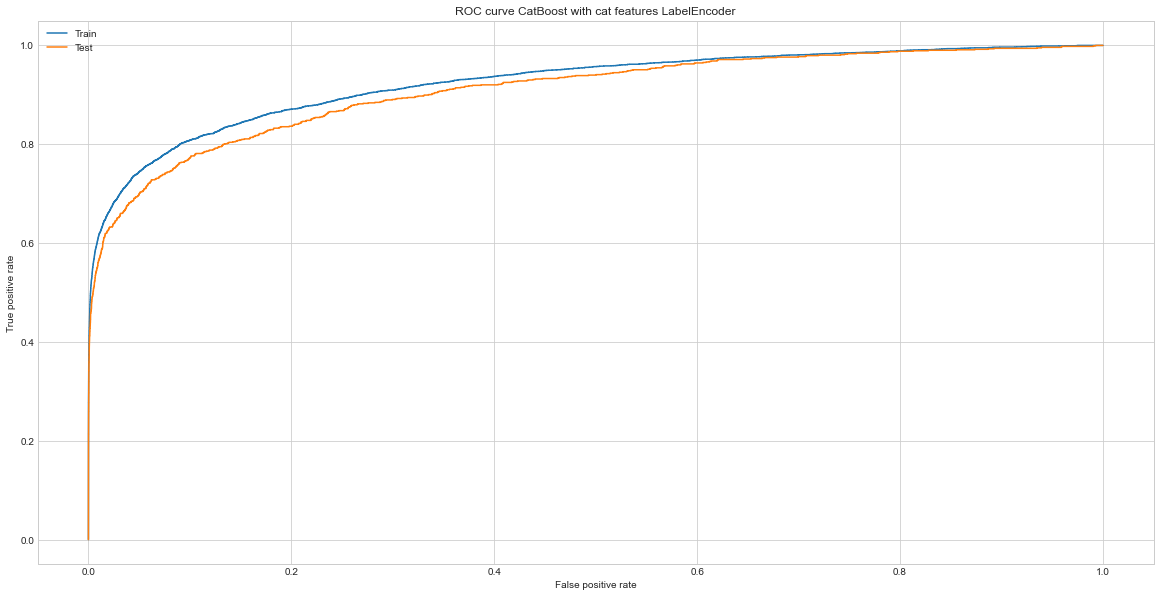

In [135]:
plt.figure(figsize=(20,10))
plt.plot(fpr_train2, tpr_train2, label='Train')
plt.plot(fpr_valid2, tpr_valid2, label='Test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve CatBoost with cat features LabelEncoder')
plt.legend()
plt.show()

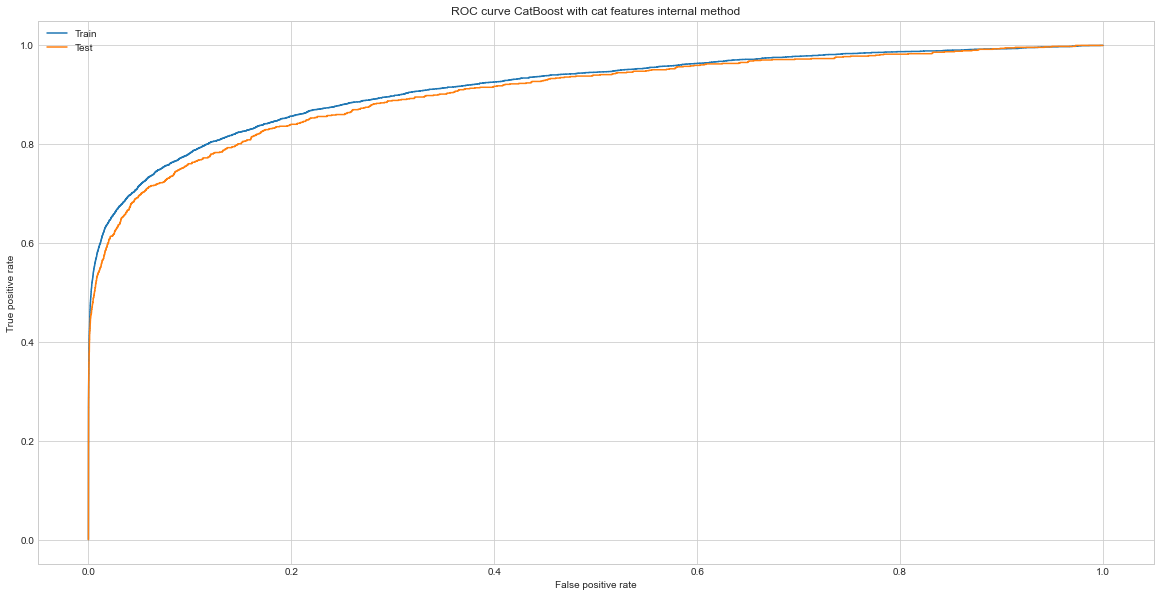

In [137]:
plt.figure(figsize=(20,10))
plt.plot(fpr_train3, tpr_train3, label='Train')
plt.plot(fpr_valid3, tpr_valid3, label='Test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve CatBoost with cat features internal method')
plt.legend()
plt.show()

### Доп. задания:

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

__Для доп.задания я буду использовать изначальный датасет, а не обработанный мною__

In [141]:
#Пустых значений в признаке нигде нет
train['TransactionDT'].isna().sum(), test['TransactionDT'].isna().sum()

(0, 0)

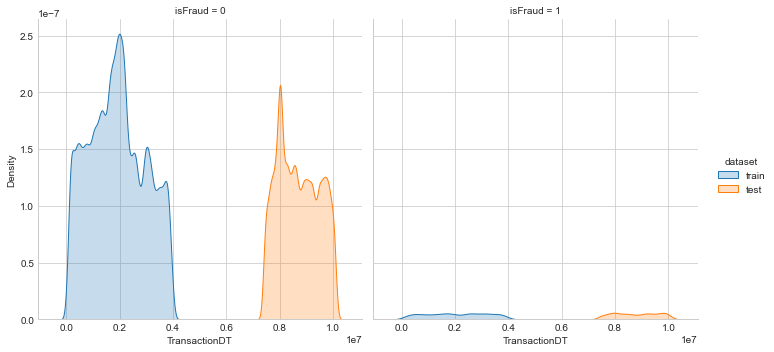

In [159]:
concatenated = pd.concat([train.assign(dataset='train'), test.assign(dataset='test')])
sns.displot(concatenated, x="TransactionDT", col=target, hue='dataset', kind="kde", fill=True)

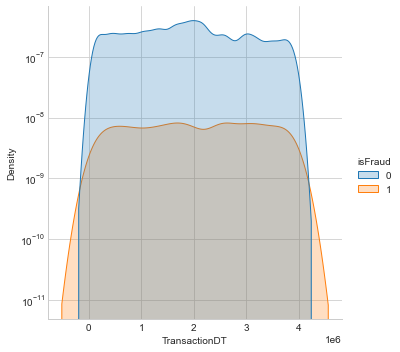

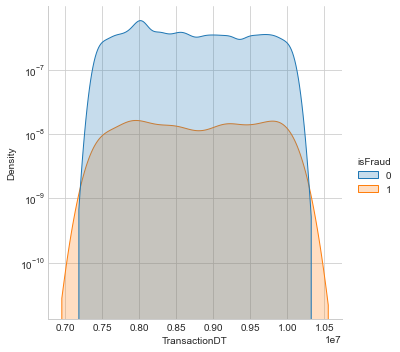

In [160]:
sns.displot(train, x="TransactionDT", hue=target, kind="kde", fill=True, log_scale=(False, True))
sns.displot(test, x="TransactionDT", hue=target, kind="kde", fill=True, log_scale=(False, True))
plt.show()

Судя по графикам выше:
- в тренировочном датасете данные относятся к одному временному промежутку, а в тестовом - к другому
- распределение существенно различаются как между тренировочным и тестовым датасетами, так и между значениями целевого класса
- поскольку с таким разбиением задача превращается в работу с датасетами, как с временными рядами, то для валидации нужно использовать кросс-валидацию без случайного перемешивания данных, т.е. вот по такой схеме:

![title](https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png)

Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

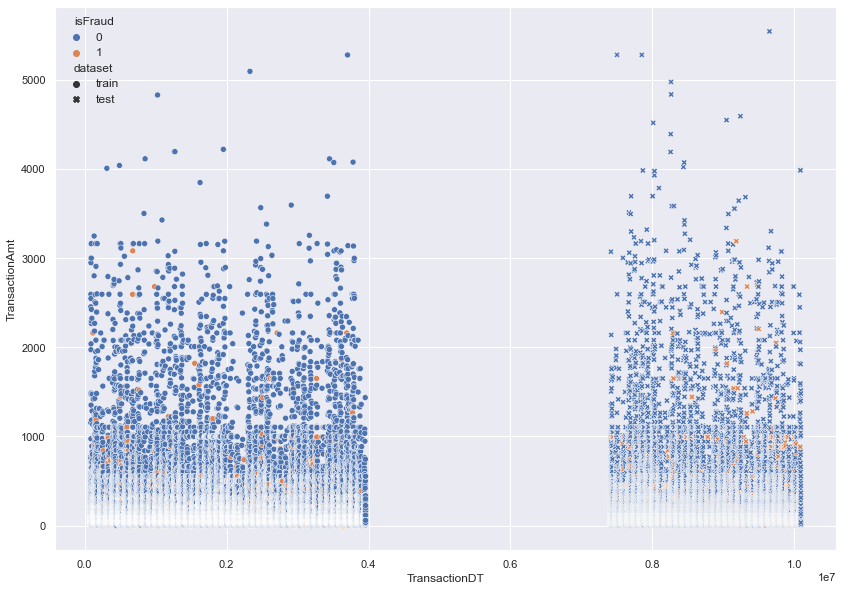

In [170]:
sns.set(rc={'figure.figsize':(14, 10)})
sns.scatterplot(x='TransactionDT', y='TransactionAmt', data=concatenated,
                hue=target, style='dataset')

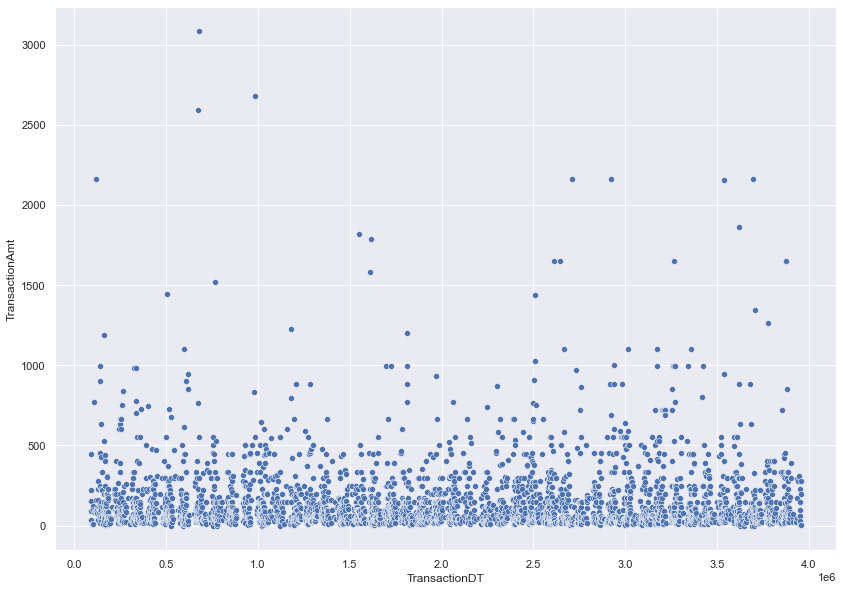

In [172]:
sns.scatterplot(x='TransactionDT', y='TransactionAmt', data=train.loc[train[target]==1])

- В обучающей выборке большая часть транзакций с целевой переменной = 1 находится в значении суммы транзакции до 500, тогда как средние суммы транзакций с целевой переменной = 0 больше. Это подтверждает и график ниже
- На графиках в тренировочной и тестовой выборке видна некая периодичность сумм транзакций - в некоторые дни она выше, чем в другие
- Также заметно, что в крайних правых значениях времени увеличивается кол-во транзакций с небольшой суммой, как в тренировочном датасете, так и в тестовом. Возможно, это праздник, типа НГ или рождества, когда покупают много небольших символических подарков.
- В тренировочном датасете примерно в середине временного промежутка видна странная просадка по кол-ву больших сумм транзакций.

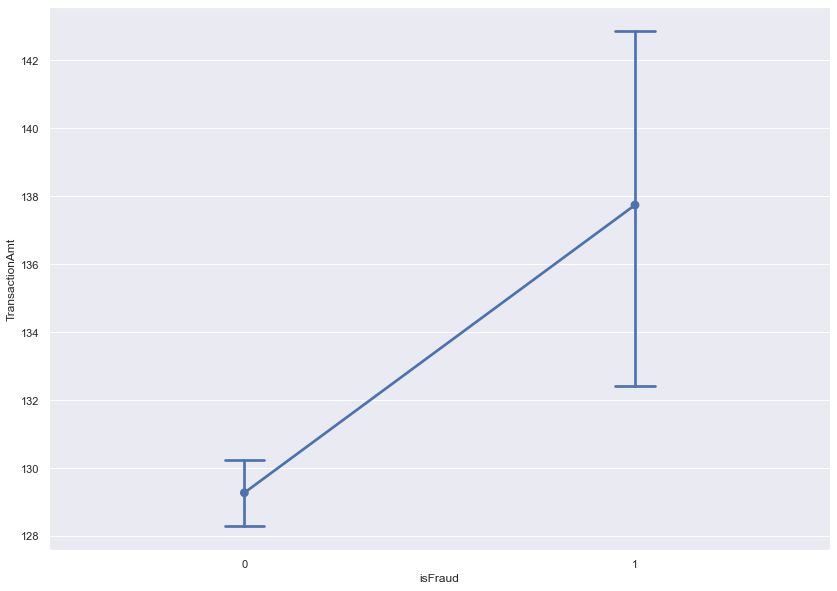

In [173]:
sns.pointplot(x=target, y='TransactionAmt', data=train, capsize=.1)

Построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

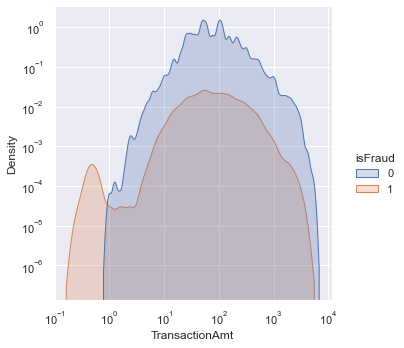

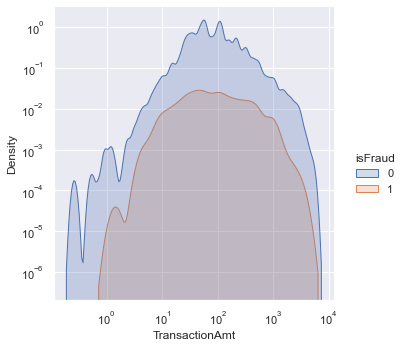

In [178]:
sns.displot(train, x="TransactionAmt", hue=target, kind="kde", fill=True, log_scale=(True, True))
sns.displot(test, x="TransactionAmt", hue=target, kind="kde", fill=True, log_scale=(True, True))
plt.show()

- Распределение не нормальное, как в тренировочной выборке, так и в тестовой

Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

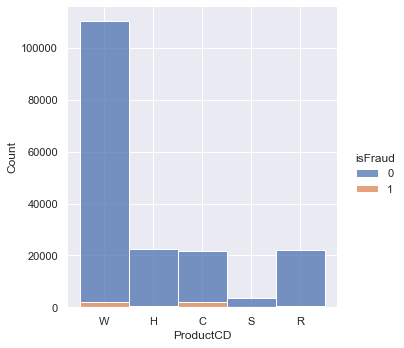

In [194]:
sns.displot(train, x="ProductCD", multiple="stack", hue=target)

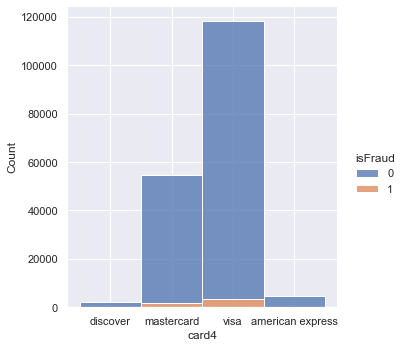

In [195]:
sns.displot(train2, x="card4", multiple="stack", hue=target)

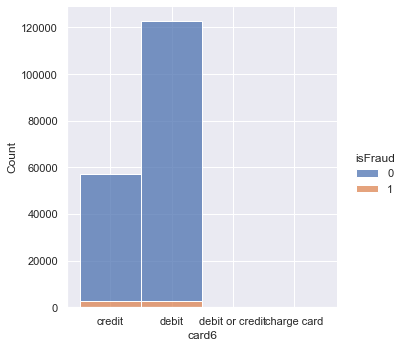

In [196]:
sns.displot(train2, x="card6", multiple="stack", hue=target)

- Во всех рассмотренных признаках значение целевой переменной = 1 находится только в 2-х соответствующих значениях этих признаков. 